In [1]:
import numpy as np
import math
import random
from PIL import Image, ImageOps, ImageEnhance
import collections
import types

"""
Original code from new_transforms.py

Taken directly from https://github.com/pytorch/vision/blob/master/torchvision/transforms.py
Latest update that is not currently deployed to pip.
All credits to the torchvision developers.
"""

# Particulars for this ipython notebook: 
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
%matplotlib inline

dir_lungTilesNormal = "/beegfs/jmw784/Capstone/LungTilesSorted/Solid_Tissue_Normal/"

### Import and Display

In [2]:
#eximg = Image.open(dir_lungTilesNormal + "valid_TCGA-93-7348-11A-01-TS1.6099aed6-04da-4208-8fdf-fd76bb78de41_9_36.jpeg")


eximg = Image.open(dir_lungTilesNormal + "test_TCGA-60-2709-11A-01-BS1.177526d2-5863-4829-ad4b-7de930de16ad_27_9.jpeg")


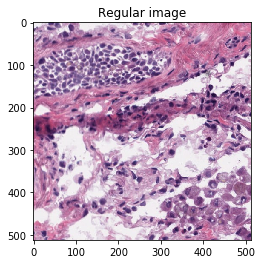

In [3]:
imshow(np.asarray(eximg))
plt.title("Regular image")

### Cropping

In [4]:
accimage = None

def _is_pil_image(img):
    if accimage is not None:
        return isinstance(img, (Image.Image, accimage.Image))
    else:
        return isinstance(img, Image.Image)

In [5]:
def crop(img, i, j, h, w):
    """Crop the given PIL.Image.
    Args:
        img (PIL.Image): Image to be cropped.
        i: Upper pixel coordinate.
        j: Left pixel coordinate.
        h: Height of the cropped image.
        w: Width of the cropped image.
    Returns:
        PIL.Image: Cropped image.
    """
    if not _is_pil_image(img):
        raise TypeError('img should be PIL Image. Got {}'.format(type(img)))

    return img.crop((j, i, j + w, i + h))

In [6]:
crop_example = crop(eximg, 100, 100, 400, 400)

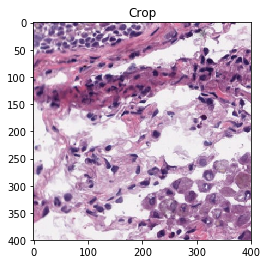

In [7]:
imshow(np.asarray(crop_example))
plt.title("Crop")

### Reseize

In [8]:
def resize(img, size, interpolation=Image.BILINEAR):
    """Resize the input PIL.Image to the given size.
    Args:
        img (PIL.Image): Image to be resized.
        size (sequence or int): Desired output size. If size is a sequence like
            (h, w), the output size will be matched to this. If size is an int,
            the smaller edge of the image will be matched to this number maintaing
            the aspect ratio. i.e, if height > width, then image will be rescaled to
            (size * height / width, size)
        interpolation (int, optional): Desired interpolation. Default is
            ``PIL.Image.BILINEAR``
    Returns:
        PIL.Image: Resized image.
    """
    if not _is_pil_image(img):
        raise TypeError('img should be PIL Image. Got {}'.format(type(img)))
    if not (isinstance(size, int) or (isinstance(size, collections.Iterable) and len(size) == 2)):
        raise TypeError('Got inappropriate size arg: {}'.format(size))

    if isinstance(size, int):
        w, h = img.size
        if (w <= h and w == size) or (h <= w and h == size):
            return img
        if w < h:
            ow = size
            oh = int(size * h / w)
            return img.resize((ow, oh), interpolation)
        else:
            oh = size
            ow = int(size * w / h)
            return img.resize((ow, oh), interpolation)
    else:
        return img.resize(size[::-1], interpolation)

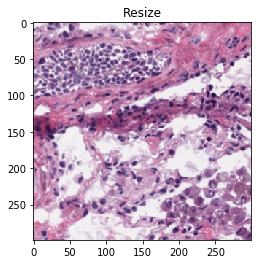

In [9]:
resize_example = resize(eximg, 299)
imshow(np.asarray(resize_example))
plt.title("Resize")

### Vflip

In [10]:
def vflip(img):
    """Vertically flip the given PIL.Image.
    Args:
        img (PIL.Image): Image to be flipped.
    Returns:
        PIL.Image:  Vertically flipped image.
    """
    if not _is_pil_image(img):
        raise TypeError('img should be PIL Image. Got {}'.format(type(img)))

    return img.transpose(Image.FLIP_TOP_BOTTOM)

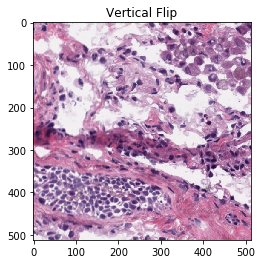

In [11]:
flip_example = vflip(eximg)
imshow(np.asarray(flip_example))
plt.title("Vertical Flip")

### Compose (class)

- <span style="color:red"> Still not geting what exactly is the point of this class </span>
- It is later use in Color Jitter Class (see below)

In [12]:
class Compose(object):
    """Composes several transforms together.
    Args:
        transforms (list of ``Transform`` objects): list of transforms to compose.
    Example:
        >>> transforms.Compose([
        >>>     transforms.CenterCrop(10),
        >>>     transforms.ToTensor(),
        >>> ])
    """

    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img):
        for t in self.transforms:
            img = t(img)
        return img

In [13]:
eximg1 = Image.open(dir_lungTilesNormal + 
                    "valid_TCGA-93-7348-11A-01-TS1.6099aed6-04da-4208-8fdf-fd76bb78de41_9_36.jpeg")
eximg2 = Image.open(dir_lungTilesNormal +
                    "valid_TCGA-93-7348-11A-01-TS1.6099aed6-04da-4208-8fdf-fd76bb78de41_44_33.jpeg")

In [14]:
compose_example = Compose([eximg1, eximg2])

### Random Vertical Flip

In [15]:
class RandomVerticalFlip(object):
    """Vertically flip the given PIL.Image randomly with a probability of 0.5."""

    def __call__(self, img):
        """
        Args:
            img (PIL.Image): Image to be flipped.
        Returns:
            PIL.Image: Randomly flipped image.
        """
        if random.random() < 0.5:
            return vflip(img)
        return img

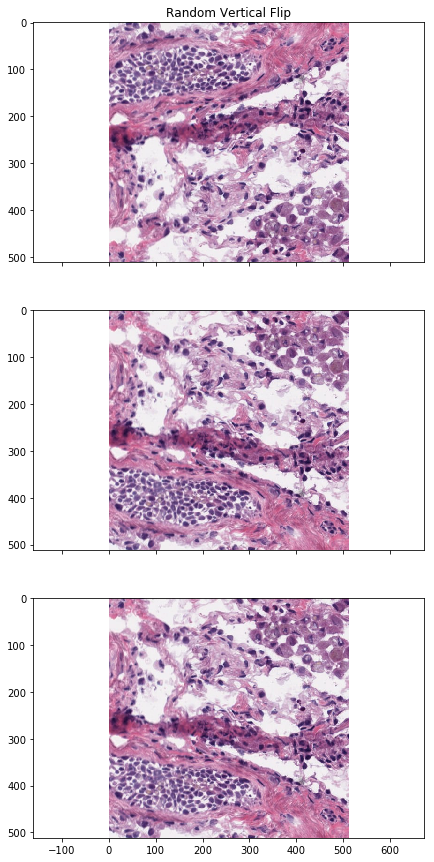

In [16]:
RandomVFlip = RandomVerticalFlip()
flip_example1 = RandomVFlip(eximg)
flip_example2 = RandomVFlip(eximg)
flip_example3 = RandomVFlip(eximg)

plt.close('all')
f, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=True)
f.set_figheight(15)
f.set_figwidth(7)
ax1.imshow(np.asarray(flip_example1))
ax2.imshow(np.asarray(flip_example2))
ax3.imshow(np.asarray(flip_example3))
ax1.set_title("Random Vertical Flip")

### Adjust Brightness

In [17]:
def adjust_brightness(img, brightness_factor):
    """Adjust brightness of an Image.
    Args:
        img (PIL.Image): PIL Image to be adjusted.
        brightness_factor (float):  How much to adjust the brightness. Can be
            any non negative number. 0 gives a black image, 1 gives the
            original image while 2 increases the brightness by a factor of 2.
    Returns:
        PIL.Image: Brightness adjusted image.
    """
    if not _is_pil_image(img):
        raise TypeError('img should be PIL Image. Got {}'.format(type(img)))

    enhancer = ImageEnhance.Brightness(img)
    img = enhancer.enhance(brightness_factor)
    return img

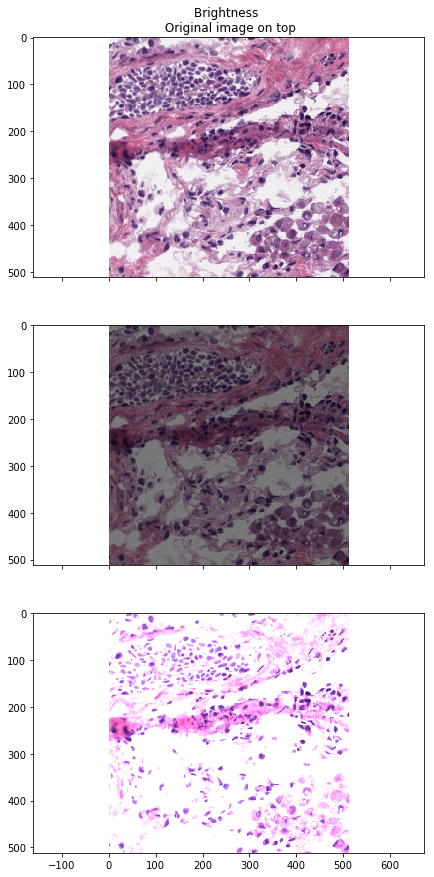

In [18]:
brightness_example1 = adjust_brightness(eximg, 1)
brightness_example2 = adjust_brightness(eximg, 0.5)
brightness_example3 = adjust_brightness(eximg, 2)

plt.close('all')
f, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=True)
f.set_figheight(15)
f.set_figwidth(7)
ax1.imshow(np.asarray(brightness_example1))
ax2.imshow(np.asarray(brightness_example2))
ax3.imshow(np.asarray(brightness_example3))
ax1.set_title("Brightness \n Original image on top")

### Adjust Contrast

In [19]:
def adjust_contrast(img, contrast_factor):
    """Adjust contrast of an Image.
    Args:
        img (PIL.Image): PIL Image to be adjusted.
        contrast_factor (float): How much to adjust the contrast. Can be any
            non negative number. 0 gives a solid gray image, 1 gives the
            original image while 2 increases the contrast by a factor of 2.
    Returns:
        PIL.Image: Contrast adjusted image.
    """
    if not _is_pil_image(img):
        raise TypeError('img should be PIL Image. Got {}'.format(type(img)))

    enhancer = ImageEnhance.Contrast(img)
    img = enhancer.enhance(contrast_factor)
    return img

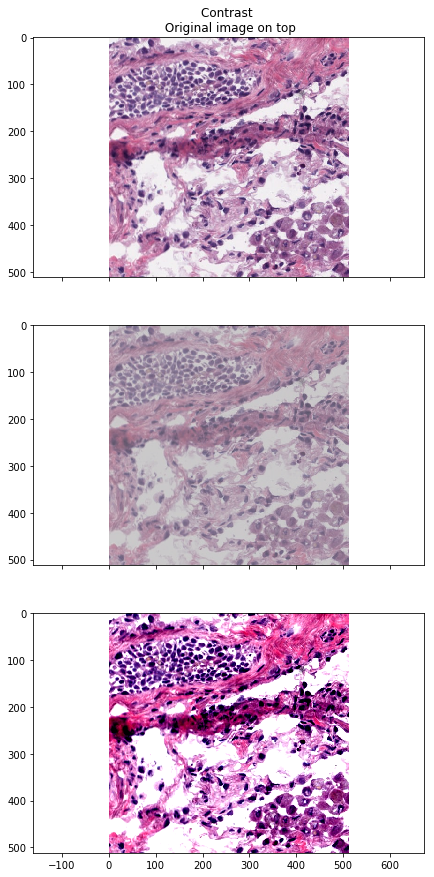

In [20]:
contrast_example1 = adjust_contrast(eximg, 1)
contrast_example2 = adjust_contrast(eximg, 0.5)
contrast_example3 = adjust_contrast(eximg, 2)

plt.close('all')
f, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=True)
f.set_figheight(15)
f.set_figwidth(7)
ax1.imshow(np.asarray(contrast_example1))
ax2.imshow(np.asarray(contrast_example2))
ax3.imshow(np.asarray(contrast_example3))
ax1.set_title("Contrast \n Original image on top")

### Adjust Saturation

In [21]:
def adjust_saturation(img, saturation_factor):
    """Adjust color saturation of an image.
    Args:
        img (PIL.Image): PIL Image to be adjusted.
        saturation_factor (float):  How much to adjust the saturation. 0 will
            give a black and white image, 1 will give the original image while
            2 will enhance the saturation by a factor of 2.
    Returns:
        PIL.Image: Saturation adjusted image.
    """
    if not _is_pil_image(img):
        raise TypeError('img should be PIL Image. Got {}'.format(type(img)))

    enhancer = ImageEnhance.Color(img)
    img = enhancer.enhance(saturation_factor)
    return img

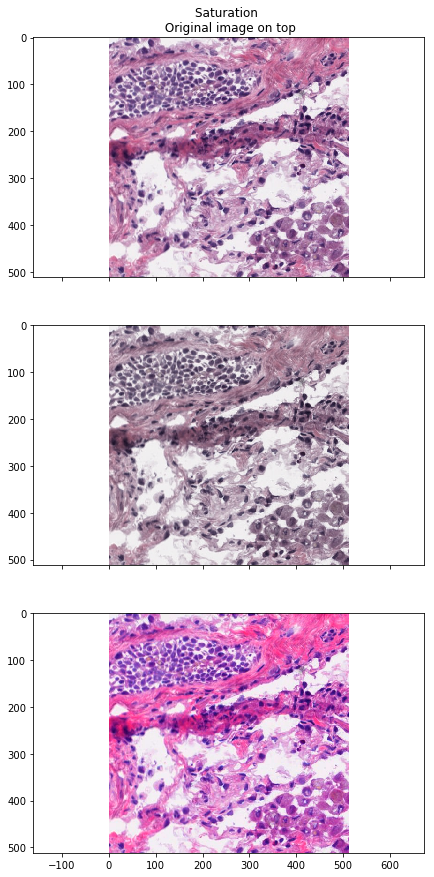

In [22]:
saturation_example1 = adjust_saturation(eximg, 1)
saturation_example2 = adjust_saturation(eximg, 0.5)
saturation_example3 = adjust_saturation(eximg, 2)

plt.close('all')
f, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=True)
f.set_figheight(15)
f.set_figwidth(7)
ax1.imshow(np.asarray(saturation_example1))
ax2.imshow(np.asarray(saturation_example2))
ax3.imshow(np.asarray(saturation_example3))
ax1.set_title("Saturation \n Original image on top")

### Adjust Hue

In [23]:
def adjust_hue(img, hue_factor):
    """Adjust hue of an image.
    The image hue is adjusted by converting the image to HSV and
    cyclically shifting the intensities in the hue channel (H).
    The image is then converted back to original image mode.
    `hue_factor` is the amount of shift in H channel and must be in the
    interval `[-0.5, 0.5]`.
    See https://en.wikipedia.org/wiki/Hue for more details on Hue.
    Args:
        img (PIL.Image): PIL Image to be adjusted.
        hue_factor (float):  How much to shift the hue channel. Should be in
            [-0.5, 0.5]. 0.5 and -0.5 give complete reversal of hue channel in
            HSV space in positive and negative direction respectively.
            0 means no shift. Therefore, both -0.5 and 0.5 will give an image
            with complementary colors while 0 gives the original image.
    Returns:
        PIL.Image: Hue adjusted image.
    """
    if not(-0.5 <= hue_factor <= 0.5):
        raise ValueError('hue_factor is not in [-0.5, 0.5].'.format(hue_factor))

    if not _is_pil_image(img):
        raise TypeError('img should be PIL Image. Got {}'.format(type(img)))

    input_mode = img.mode
    if input_mode in {'L', '1', 'I', 'F'}:
        return img

    h, s, v = img.convert('HSV').split()

    np_h = np.array(h, dtype=np.uint8)
    # uint8 addition take cares of rotation across boundaries
    with np.errstate(over='ignore'):
        np_h += np.uint8(hue_factor * 255)
    h = Image.fromarray(np_h, 'L')

    img = Image.merge('HSV', (h, s, v)).convert(input_mode)
    return img

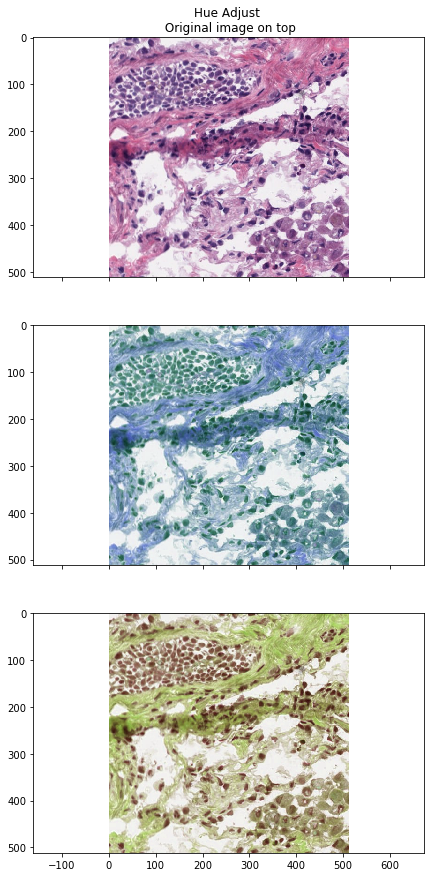

In [24]:
hue_example1 = adjust_hue(eximg, 0)
hue_example2 = adjust_hue(eximg, -0.3)
hue_example3 = adjust_hue(eximg, 0.3)

plt.close('all')
f, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=True)
f.set_figheight(15)
f.set_figwidth(7)
ax1.imshow(np.asarray(hue_example1))
ax2.imshow(np.asarray(hue_example2))
ax3.imshow(np.asarray(hue_example3))
ax1.set_title("Hue Adjust \n Original image on top")

### Adjust Gamma

In [27]:
def adjust_gamma(img, gamma, gain=1):
    """Perform gamma correction on an image.
    Also known as Power Law Transform. Intensities in RGB mode are adjusted
    based on the following equation:
        I_out = 255 * gain * ((I_in / 255) ** gamma)
    See https://en.wikipedia.org/wiki/Gamma_correction for more details.
    Args:
        img (PIL.Image): PIL Image to be adjusted.
        gamma (float): Non negative real number. gamma larger than 1 make the
            shadows darker, while gamma smaller than 1 make dark regions
            lighter.
        gain (float): The constant multiplier.
    """
    if not _is_pil_image(img):
        raise TypeError('img should be PIL Image. Got {}'.format(type(img)))

    if gamma < 0:
        raise ValueError('Gamma should be a non-negative real number')

    input_mode = img.mode
    img = img.convert('RGB')

    np_img = np.array(img, dtype=np.float32)
    np_img = 255 * gain * ((np_img / 255) ** gamma)
    np_img = np.uint8(np.clip(np_img, 0, 255))

    img = Image.fromarray(np_img, 'RGB').convert(input_mode)
    return img

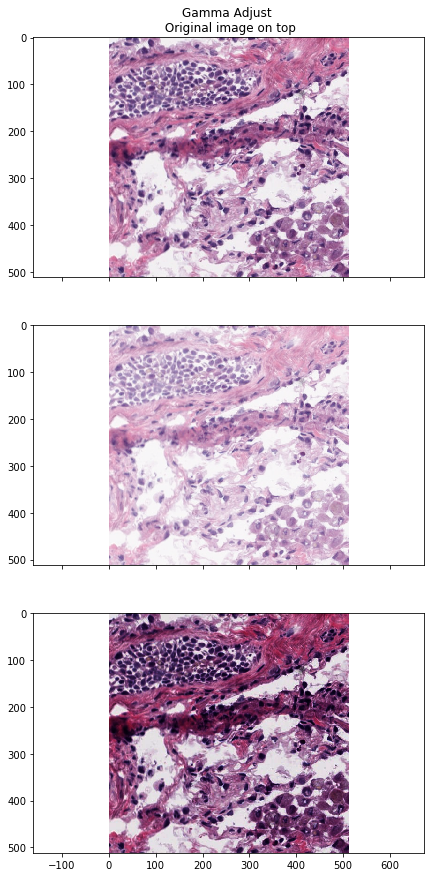

In [28]:
gamma_example1 = adjust_gamma(eximg, 1)
gamma_example2 = adjust_gamma(eximg, 0.5)
gamma_example3 = adjust_gamma(eximg, 2)

plt.close('all')
f, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=True)
f.set_figheight(15)
f.set_figwidth(7)
ax1.imshow(np.asarray(gamma_example1))
ax2.imshow(np.asarray(gamma_example2))
ax3.imshow(np.asarray(gamma_example3))
ax1.set_title("Gamma Adjust \n Original image on top")

### Resized Crop

In [29]:
def resized_crop(img, i, j, h, w, size, interpolation=Image.BILINEAR):
    """Crop the given PIL.Image and resize it to desired size.
    Notably used in RandomResizedCrop.
    Args:
        img (PIL.Image): Image to be cropped.
        i: Upper pixel coordinate.
        j: Left pixel coordinate.
        h: Height of the cropped image.
        w: Width of the cropped image.
        size (sequence or int): Desired output size. Same semantics as ``scale``.
        interpolation (int, optional): Desired interpolation. Default is
            ``PIL.Image.BILINEAR``.
    Returns:
        PIL.Image: Cropped image.
    """
    assert _is_pil_image(img), 'img should be PIL Image'
    img = crop(img, i, j, h, w)
    img = resize(img, size, interpolation)
    return img

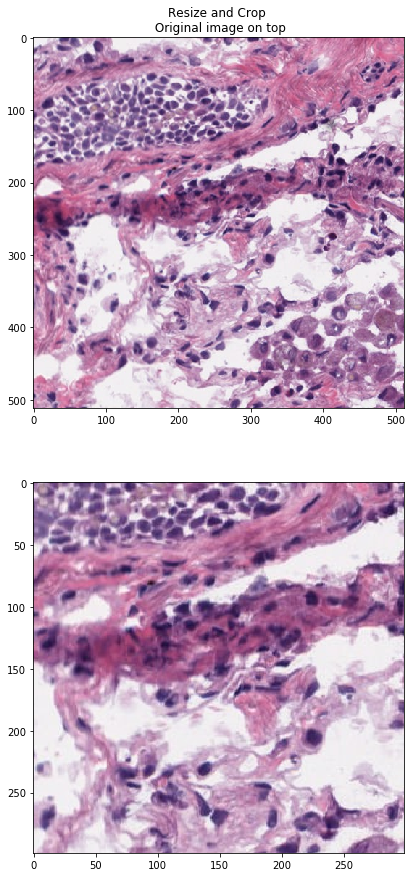

In [30]:
resized_crop_example = resized_crop(eximg, 100, 100, 299, 299, 299)

plt.close('all')
f, (ax1, ax2) = plt.subplots(2, sharex=False, sharey=False)
f.set_figheight(15)
f.set_figwidth(7)
ax1.imshow(np.asarray(eximg))
ax2.imshow(np.asarray(resized_crop_example))
ax1.set_title("Resize and Crop \n Original image on top")

In [31]:
# And the class

class RandomResizedCrop(object):
    
    """Crop the given PIL.Image to random size and aspect ratio.
    A crop of random size of (0.08 to 1.0) of the original size and a random
    aspect ratio of 3/4 to 4/3 of the original aspect ratio is made. This crop
    is finally resized to given size.
    This is popularly used to train the Inception networks.
    Args:
        size: expected output size of each edge
        interpolation: Default: PIL.Image.BILINEAR
    """

    def __init__(self, size, interpolation=Image.BILINEAR):
        self.size = (size, size)
        self.interpolation = interpolation

    @staticmethod
    def get_params(img):
        """Get parameters for ``crop`` for a random sized crop.
        Args:
            img (PIL.Image): Image to be cropped.
        Returns:
            tuple: params (i, j, h, w) to be passed to ``crop`` for a random
                sized crop.
        """
        for attempt in range(10):
            area = img.size[0] * img.size[1]
            target_area = random.uniform(0.08, 1.0) * area
            aspect_ratio = random.uniform(3. / 4, 4. / 3)

            w = int(round(math.sqrt(target_area * aspect_ratio)))
            h = int(round(math.sqrt(target_area / aspect_ratio)))

            if random.random() < 0.5:
                w, h = h, w

            if w <= img.size[0] and h <= img.size[1]:
                i = random.randint(0, img.size[1] - h)
                j = random.randint(0, img.size[0] - w)
                return i, j, h, w

        # Fallback
        w = min(img.size[0], img.size[1])
        i = (img.size[1] - w) // 2
        j = (img.size[0] - w) // 2
        return i, j, w, w

    def __call__(self, img):
        """
        Args:
            img (PIL.Image): Image to be flipped.
        Returns:
            PIL.Image: Randomly cropped and resize image.
        """
        i, j, h, w = self.get_params(img)
        return resized_crop(img, i, j, h, w, self.size, self.interpolation)

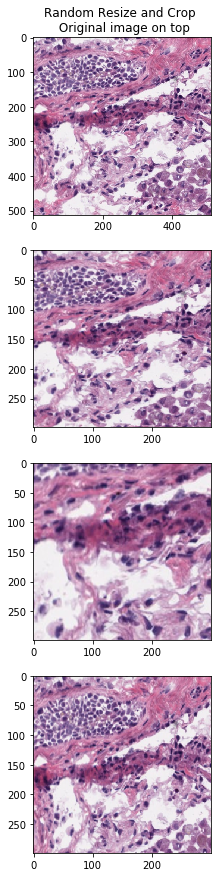

In [32]:
randomResizedCrop = RandomResizedCrop(299)
resized_crop_example1 = randomResizedCrop(eximg)
resized_crop_example2 = randomResizedCrop(eximg)
resized_crop_example3 = randomResizedCrop(eximg)

plt.close('all')
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, sharex=False, sharey=False)
f.set_figheight(15)
f.set_figwidth(7)
ax1.imshow(np.asarray(eximg))
ax2.imshow(np.asarray(resized_crop_example1))
ax3.imshow(np.asarray(resized_crop_example2))
ax4.imshow(np.asarray(resized_crop_example3))
ax1.set_title("Random Resize and Crop \n Original image on top")

### Class Lambda

- <span style="color:red"> Just as compose, still not geting what exactly is the point of this class </span>
- It is later used in Color Jitter, see below

In [33]:
class Lambda(object):
    """Apply a user-defined lambda as a transform.
    Args:
        lambd (function): Lambda/function to be used for transform.
    """

    def __init__(self, lambd):
        assert isinstance(lambd, types.LambdaType)
        self.lambd = lambd

    def __call__(self, img):
        return self.lambd(img)

### Class ColorJitter

In [34]:
class ColorJitter(object):
    """Randomly change the brightness, contrast and saturation of an image.
    Args:
        brightness (float): How much to jitter brightness. brightness_factor
            is chosen uniformly from [max(0, 1 - brightness), 1 + brightness].
        contrast (float): How much to jitter contrast. contrast_factor
            is chosen uniformly from [max(0, 1 - contrast), 1 + contrast].
        saturation (float): How much to jitter saturation. saturation_factor
            is chosen uniformly from [max(0, 1 - saturation), 1 + saturation].
        hue(float): How much to jitter hue. hue_factor is chosen uniformly from
            [-hue, hue]. Should be >=0 and <= 0.5.
    """
    def __init__(self, brightness=0, contrast=0, saturation=0, hue=0):
        self.brightness = brightness
        self.contrast = contrast
        self.saturation = saturation
        self.hue = hue

    @staticmethod
    def get_params(brightness, contrast, saturation, hue):
        """Get a randomized transform to be applied on image.
        Arguments are same as that of __init__.
        Returns:
            Transform which randomly adjusts brightness, contrast and
            saturation in a random order.
        """
        transforms = []
        if brightness > 0:
            brightness_factor = np.random.uniform(max(0, 1 - brightness), 1 + brightness)
            transforms.append(Lambda(lambda img: adjust_brightness(img, brightness_factor)))

        if contrast > 0:
            contrast_factor = np.random.uniform(max(0, 1 - contrast), 1 + contrast)
            transforms.append(Lambda(lambda img: adjust_contrast(img, contrast_factor)))

        if saturation > 0:
            saturation_factor = np.random.uniform(max(0, 1 - saturation), 1 + saturation)
            transforms.append(Lambda(lambda img: adjust_saturation(img, saturation_factor)))

        if hue > 0:
            hue_factor = np.random.uniform(-hue, hue)
            transforms.append(Lambda(lambda img: adjust_hue(img, hue_factor)))

        np.random.shuffle(transforms)
        transform = Compose(transforms)

        return transform

    def __call__(self, img):
        """
        Args:
            img (PIL.Image): Input image.
        Returns:
            PIL.Image: Color jittered image.
        """
        transform = self.get_params(self.brightness, self.contrast,
                                    self.saturation, self.hue)
        return transform(img)

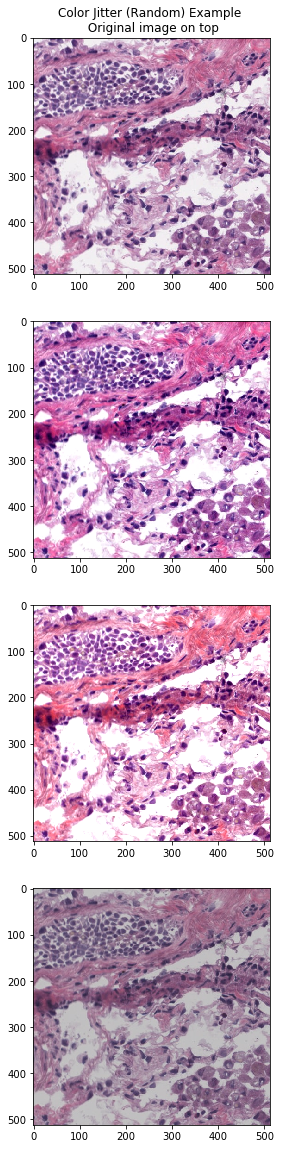

In [35]:
# Played with default parameters. Think this is fine
cJitter = ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.05)

ColorJitter_example1 = cJitter(eximg)
ColorJitter_example2 = cJitter(eximg)
ColorJitter_example3 = cJitter(eximg)

plt.close('all')
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, sharex=False, sharey=False)
f.set_figheight(20)
f.set_figwidth(7)
ax1.imshow(np.asarray(eximg))
ax2.imshow(np.asarray(ColorJitter_example1))
ax3.imshow(np.asarray(ColorJitter_example2))
ax4.imshow(np.asarray(ColorJitter_example3))
ax1.set_title("Color Jitter (Random) Example \n Original image on top")

### Try a 90 degree rotation

In [36]:
def adjust_rotation(img, degree=90):
    """Vertically flip the given PIL.Image.
    Args:
        img (PIL.Image): Image to be flipped.
        degree: Angle to rotate: 0 to 360
    Returns:
        PIL.Image:  Rotated image.
    """
    if not _is_pil_image(img):
        raise TypeError('img should be PIL Image. Got {}'.format(type(img)))
        
    if degree<0: 
        raise ValueError('Negative rotation - Select degree between 0 and 360')
        
    if degree>360: 
        raise ValueError('Negative rotation - Select degree between 0 and 360')

    return img.rotate(degree)

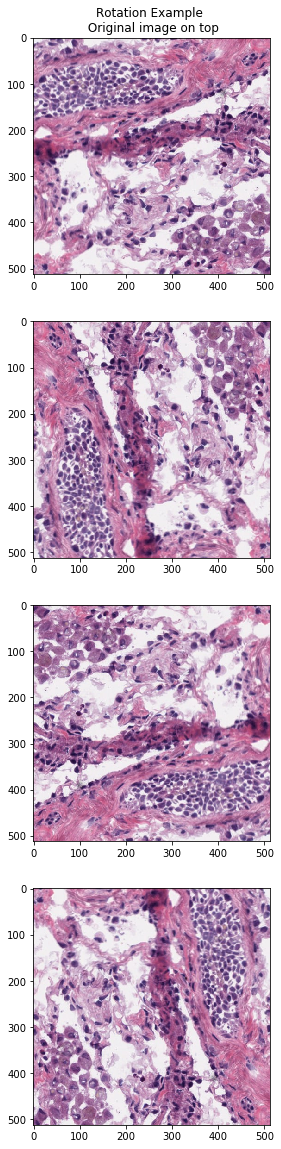

In [37]:
rotate_example1 = adjust_rotation(eximg, 90)
rotate_example2 = adjust_rotation(eximg, 180)
rotate_example3 = adjust_rotation(eximg, 270)

plt.close('all')
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, sharex=False, sharey=False)
f.set_figheight(20)
f.set_figwidth(7)
ax1.imshow(np.asarray(eximg))
ax2.imshow(np.asarray(rotate_example1))
ax3.imshow(np.asarray(rotate_example2))
ax4.imshow(np.asarray(rotate_example3))
ax1.set_title("Rotation Example \n Original image on top")

### Class: ColorJitter + Rotate

In [38]:
class ColorJitterRotate(object):
    """Randomly change the brightness, contrast and saturation of an image.
    Args:
        brightness (float): How much to jitter brightness. brightness_factor
            is chosen uniformly from [max(0, 1 - brightness), 1 + brightness].
        contrast (float): How much to jitter contrast. contrast_factor
            is chosen uniformly from [max(0, 1 - contrast), 1 + contrast].
        saturation (float): How much to jitter saturation. saturation_factor
            is chosen uniformly from [max(0, 1 - saturation), 1 + saturation].
        hue(float): How much to jitter hue. hue_factor is chosen uniformly from
            [-hue, hue]. Should be >=0 and <= 0.5.
        rotation: Rotate image randomly from 0 to the defined parameter
    """
    def __init__(self, brightness=0, contrast=0, saturation=0, hue=0, rotation=0):
        self.brightness = brightness
        self.contrast = contrast
        self.saturation = saturation
        self.hue = hue
        self.rotation = rotation

    @staticmethod
    def get_params(brightness, contrast, saturation, hue, rotation):
        """Get a randomized transform to be applied on image.
        Arguments are same as that of __init__.
        Returns:
            Transform which randomly adjusts brightness, contrast and
            saturation in a random order.
        """
        transforms = []
        if brightness > 0:
            brightness_factor = np.random.uniform(max(0, 1 - brightness), 1 + brightness)
            transforms.append(Lambda(lambda img: adjust_brightness(img, brightness_factor)))

        if contrast > 0:
            contrast_factor = np.random.uniform(max(0, 1 - contrast), 1 + contrast)
            transforms.append(Lambda(lambda img: adjust_contrast(img, contrast_factor)))

        if saturation > 0:
            saturation_factor = np.random.uniform(max(0, 1 - saturation), 1 + saturation)
            transforms.append(Lambda(lambda img: adjust_saturation(img, saturation_factor)))

        if hue > 0:
            hue_factor = np.random.uniform(-hue, hue)
            transforms.append(Lambda(lambda img: adjust_hue(img, hue_factor)))
        
        if rotation > 0: 
            rotation_factor = np.random.uniform(0, rotation)
            transforms.append(Lambda(lambda img: adjust_rotation(img, rotation_factor)))

        np.random.shuffle(transforms)
        transform = Compose(transforms)

        return transform

    def __call__(self, img):
        """
        Args:
            img (PIL.Image): Input image.
        Returns:
            PIL.Image: Color jittered image.
        """
        transform = self.get_params(self.brightness, self.contrast,
                                    self.saturation, self.hue, self.rotation)
        return transform(img)

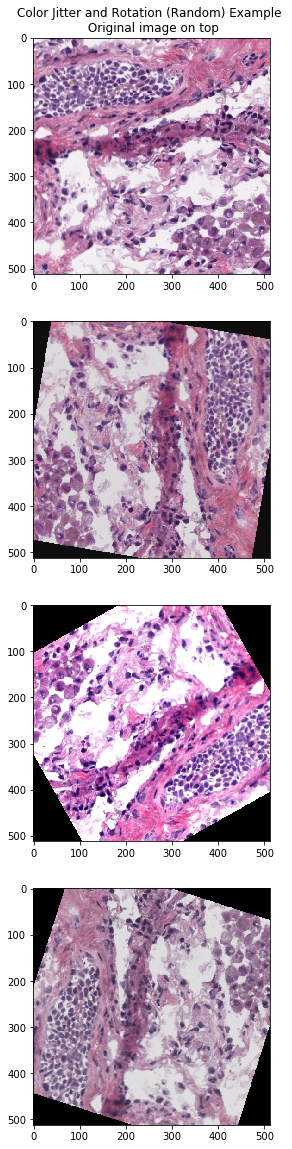

In [39]:
# Played with default parameters. Think this is fine
cJitterRotate = ColorJitterRotate(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.05, rotation=270)

ColorJitterR_example1 = cJitterRotate(eximg)
ColorJitterR_example2 = cJitterRotate(eximg)
ColorJitterR_example3 = cJitterRotate(eximg)

plt.close('all')
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, sharex=False, sharey=False)
f.set_figheight(20)
f.set_figwidth(7)
ax1.imshow(np.asarray(eximg))
ax2.imshow(np.asarray(ColorJitterR_example1))
ax3.imshow(np.asarray(ColorJitterR_example2))
ax4.imshow(np.asarray(ColorJitterR_example3))
ax1.set_title("Color Jitter and Rotation (Random) Example \n Original image on top")

### Class: ColorJitter + Rotate (0, 90, 180 or 270)

In [38]:
class ColorJitterRotate(object):
    """Randomly change the brightness, contrast and saturation of an image.
    Args:
        brightness (float): How much to jitter brightness. brightness_factor
            is chosen uniformly from [max(0, 1 - brightness), 1 + brightness].
        contrast (float): How much to jitter contrast. contrast_factor
            is chosen uniformly from [max(0, 1 - contrast), 1 + contrast].
        saturation (float): How much to jitter saturation. saturation_factor
            is chosen uniformly from [max(0, 1 - saturation), 1 + saturation].
        hue(float): How much to jitter hue. hue_factor is chosen uniformly from
            [-hue, hue]. Should be >=0 and <= 0.5.
        rotation: Rotate image randomly 0 to the defined parameter, fixed between (0, 90, 180, 270)
    """
    def __init__(self, brightness=0, contrast=0, saturation=0, hue=0, rotation=0):
        self.brightness = brightness
        self.contrast = contrast
        self.saturation = saturation
        self.hue = hue
        self.rotation = rotation

    @staticmethod
    def get_params(brightness, contrast, saturation, hue, rotation):
        """Get a randomized transform to be applied on image.
        Arguments are same as that of __init__.
        Returns:
            Transform which randomly adjusts brightness, contrast and
            saturation in a random order.
        """
        transforms = []
        if brightness > 0:
            brightness_factor = np.random.uniform(max(0, 1 - brightness), 1 + brightness)
            transforms.append(Lambda(lambda img: adjust_brightness(img, brightness_factor)))

        if contrast > 0:
            contrast_factor = np.random.uniform(max(0, 1 - contrast), 1 + contrast)
            transforms.append(Lambda(lambda img: adjust_contrast(img, contrast_factor)))

        if saturation > 0:
            saturation_factor = np.random.uniform(max(0, 1 - saturation), 1 + saturation)
            transforms.append(Lambda(lambda img: adjust_saturation(img, saturation_factor)))

        if hue > 0:
            hue_factor = np.random.uniform(-hue, hue)
            transforms.append(Lambda(lambda img: adjust_hue(img, hue_factor)))
        
        if rotation > 0: 
            rotation_factor = np.random.uniform(0, rotation)
            rotation_factor =  min([0,90,180,270,360], key=lambda x:abs(x-rotation_factor))
            transforms.append(Lambda(lambda img: adjust_rotation(img, rotation_factor)))

        np.random.shuffle(transforms)
        transform = Compose(transforms)

        return transform

    def __call__(self, img):
        """
        Args:
            img (PIL.Image): Input image.
        Returns:
            PIL.Image: Color jittered image.
        """
        transform = self.get_params(self.brightness, self.contrast,
                                    self.saturation, self.hue, self.rotation)
        return transform(img)

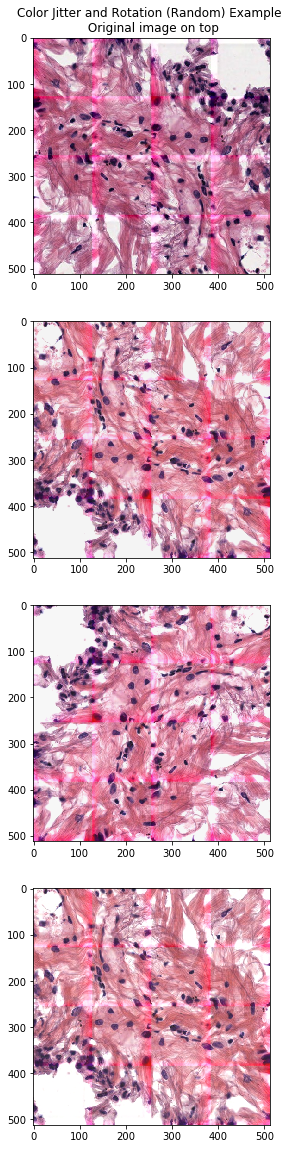

In [39]:
cJitterRotate = ColorJitterRotate(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.05, rotation=270)

ColorJitterR_example1 = cJitterRotate(eximg)
ColorJitterR_example2 = cJitterRotate(eximg)
ColorJitterR_example3 = cJitterRotate(eximg)

plt.close('all')
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, sharex=False, sharey=False)
f.set_figheight(20)
f.set_figwidth(7)
ax1.imshow(np.asarray(eximg))
ax2.imshow(np.asarray(ColorJitterR_example1))
ax3.imshow(np.asarray(ColorJitterR_example2))
ax4.imshow(np.asarray(ColorJitterR_example3))
ax1.set_title("Color Jitter and Rotation (Random) Example \n Original image on top")

### Class: Rotate (by itself)

In [75]:
class RandomRotate(object):
    """Randomly change the Rotation of an image (0/90/180/270).
    
    Args:
        rotation: Rotate image randomly to the defined parameter, fixed between (0, 90, 180, 270)
        
    """
    def __init__(self, rotation=0):
        self.rotation = rotation
        
    def intToDegrees(inte):
    
        if inte == 0: 
            rot = 0
        if inte == 1: 
            rot = 90
        if inte == 2: 
            rot = 180
        if inte == 3:
            rot = 270
        
        return rot

    @staticmethod
    def get_params(rotation):
        
        transforms = []
        rotation_factor = np.random.randint(0, 4, 1)
        rotation_factor =  intToDegrees(rotation_factor)
        transforms.append(Lambda(lambda img: adjust_rotation(img, rotation_factor)))

        np.random.shuffle(transforms)
        transform = Compose(transforms)

        return transform

    def __call__(self, img):
        """
        Args:
            img (PIL.Image): Input image.
        Returns:
            PIL.Image: Randomly rotated image.
        """
        transform = self.get_params(self.rotation)
        
        return transform(img)

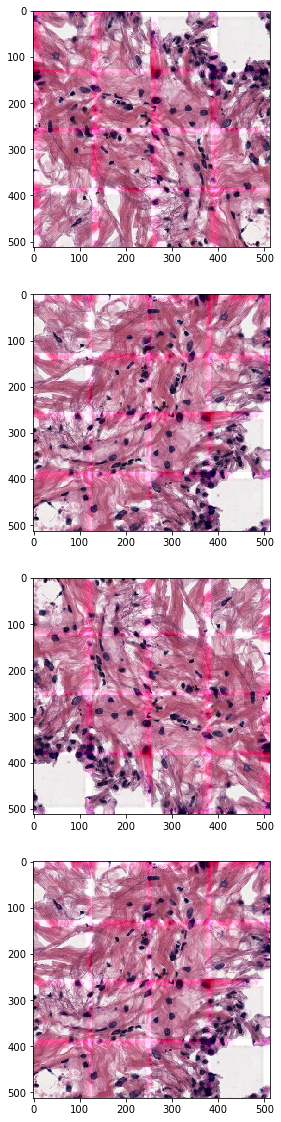

In [77]:
cRandomRotate = RandomRotate()

RandomRotate_example1 = cRandomRotate(eximg)
RandomRotate_example2 = cRandomRotate(eximg)
RandomRotate_example3 = cRandomRotate(eximg)

plt.close('all')
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, sharex=False, sharey=False)
f.set_figheight(20)
f.set_figwidth(7)
ax1.imshow(np.asarray(eximg))
ax2.imshow(np.asarray(RandomRotate_example1))
ax3.imshow(np.asarray(RandomRotate_example2))
ax4.imshow(np.asarray(RandomRotate_example3))